# QUESTION 1 : QUELLES SONT LES CARACTERISTIQUES DU DECIDEUR QUI PEUVENT LE RENDRE PLUS ENCLIN A SOUHAITER UN DEUXIEME RENDEZ-VOUS ?

In [25]:
# Importation des librairies

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from bioinfokit.analys import stat
from mpl_toolkits.mplot3d import axes3d

pio.renderers.default = "notebook"

# 1. Importation & data management

In [26]:
# Importation du dataset 

data = pd.read_csv("C:/Users/LN/Documents/Formations/Jedha/2. Exploratory Data Analysis/Speed Dating Data.csv", encoding='cp1252')
data = pd.DataFrame(data)

init_shape = data.shape

## 1.1. Data management global 

1. Suppression des vagues 12, 16, 6, 18, 19, 20, 21 comme suggéré par les auteurs
- Une vague (12) a été supprimée car le nombre maximum de participants n'a pas été respecté
- Deux vagues (16, 6) ont été supprimées parce qu'au contraire, elles n'ont pas attiré suffisamment de participants 
- Quatre vagues (18, 19, 20, 21) ont été supprimées car elles impliquaient une variante expérimentale (amener son livre favori) et donc peuvent s'avérer différentes des autres vagues 

2. Suppression des vagues pour lesquelles les quotations ont drastiquement changé entre les vagues (non comparables) : 6 à 9

3. Suppresion des variables avec 40% ou + de données manquantes

4. Suppression des participants (Deciders / Partners) ayant un age >= 35 (outliers : recrutement prévu pour les étudiants - https://www.statista.com/statistics/240152/age-distribution-of-us-doctorate-recipients/)

In [27]:
# Suppression des vagues ciblées par les auteurs

data = data[~ data.wave.isin([12, 16, 6, 18, 19, 20, 21])]

# Suppression des vagues pour lesquelles les quotations ont drastiquement changé entre les vagues 

data = data[~ data.wave.isin([6, 7, 8, 9])]

# Suppression des colonnes avec 40% ou + de NA

Col_na = data.isna().mean()
#print("{} variables présentent 40% ou plus de données manquantes et seront ignorées : {}".format(len(Col_na[Col_na >= .4].index), list(Col_na[Col_na >= .4].index)))
print("{} variables présentent 40% ou plus de données manquantes et seront ignorées".format(len(Col_na[Col_na >= .4].index)))
print("")
data = data.loc[:, data.isna().mean() < .4]

# Suppression des observations relatives à des iid ou pid age > 35

data = data.drop(data[data["age"] >= 35].index)
data = data.drop(data[data["age_o"] >= 35].index)

# Suppresion des duplicates (Pas de duplicated rows)

data = data.drop_duplicates()

# Bilan 

final_shape = data.shape
print("Au depart, la base de données contenait {} lignes / colonnes pour contenir in fine {} lignes / colonnes".format(init_shape, final_shape))
print("")

83 variables présentent 40% ou plus de données manquantes et seront ignorées

Au depart, la base de données contenait (8378, 195) lignes / colonnes pour contenir in fine (4592, 112) lignes / colonnes



## 1.2. Formatage des données nécessaire au traitement de la question 

La variable d'intérêt ici est : **Decision** (dec) 

Les **caractéristiques à baseline du décideur** présentes dans le dataset sont : 

- Variables Socio Démographiques : gender, age, field_cd, race, from, zipcode, career_c
- Variables d'importance et d'attentes : imprace, imprelig, goal, date, go_out, exhappy
- Centres d'intérêt : Sports, tvsports, exercise, dining, museums, art, hiking, gaming, clubbing, reading, tv, theater, movies, concerts, music, shopping, yoga
- Ce qu'il recherche chez l'autre : attr1_1, sinc1_1, intel1_1, fun1_1, amb1_1, shar1_1
- Comment il se percoit : attr3_1, sinc3_1, intel3_1, fun3_1, amb3_1, shar3_1
- Comment il a été percu par le partenaire : attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o

Comme tous les participants n'ont pas eu le même nombre de dates et que la tendance à vouloir un second rendez-vous peut être différente de personne en personne indépendemment des variables investiguées ici (non independance des données), nous allons transformer le dataset de sorte à ne garder qu'une ligne par participant (aggregation sur la variable iid).
La variable d'interet DEC sera donc la *proportion de dates pour lesquels le décideur a indiqué souhaiter un deuxième rendez-vous*. 

In [28]:
dec_agg_iid = data.groupby(['iid']).agg({'dec': 'mean', 
                                         'age' : lambda x: list(pd.Series.unique(x))[0], 
                                         'gender' : lambda x: list(pd.Series.unique(x))[0], 
                                         'field_cd' : lambda x: list(pd.Series.unique(x))[0], 
                                         'race' : lambda x: list(pd.Series.unique(x))[0], 
                                         'from' : lambda x: list(pd.Series.unique(x))[0], 
                                         'zipcode' : lambda x: list(pd.Series.unique(x))[0], 
                                         'imprace' : lambda x: list(pd.Series.unique(x))[0], 
                                         'imprelig' : lambda x: list(pd.Series.unique(x))[0], 
                                         'goal' : lambda x: list(pd.Series.unique(x))[0], 
                                         'date' : lambda x: list(pd.Series.unique(x))[0], 
                                         'go_out' : lambda x: list(pd.Series.unique(x))[0], 
                                         'career_c' : lambda x: list(pd.Series.unique(x))[0], 
                                         'sports' : lambda x: list(pd.Series.unique(x))[0], 
                                         'tvsports' : lambda x: list(pd.Series.unique(x))[0], 
                                         'exercise' : lambda x: list(pd.Series.unique(x))[0], 
                                         'dining' : lambda x: list(pd.Series.unique(x))[0], 
                                         'museums' : lambda x: list(pd.Series.unique(x))[0], 
                                         'art' : lambda x: list(pd.Series.unique(x))[0], 
                                         'hiking' : lambda x: list(pd.Series.unique(x))[0], 
                                         'gaming' : lambda x: list(pd.Series.unique(x))[0], 
                                         'clubbing' : lambda x: list(pd.Series.unique(x))[0], 
                                         'reading' : lambda x: list(pd.Series.unique(x))[0], 
                                         'tv' : lambda x: list(pd.Series.unique(x))[0], 
                                         'theater' : lambda x: list(pd.Series.unique(x))[0], 
                                         'movies' : lambda x: list(pd.Series.unique(x))[0], 
                                         'concerts' : lambda x: list(pd.Series.unique(x))[0], 
                                         'music' : lambda x: list(pd.Series.unique(x))[0], 
                                         'shopping' : lambda x: list(pd.Series.unique(x))[0], 
                                         'yoga' : lambda x: list(pd.Series.unique(x))[0], 
                                         'exphappy' : lambda x: list(pd.Series.unique(x))[0], 
                                         'attr1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'sinc1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'fun1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'intel1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'amb1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'shar1_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'attr3_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'sinc3_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'fun3_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'intel3_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'amb3_1' : lambda x: list(pd.Series.unique(x))[0], 
                                         'attr_o' : 'mean', 
                                         'sinc_o' : 'mean', 
                                         'fun_o' : 'mean', 
                                         'intel_o' : 'mean', 
                                         'shar_o' : 'mean', 
                                         'amb_o' : 'mean'
                                         })


**Tips** : La librairie pandas_profiling propose une fonction pour générer automatiquement un Report - une description basique de la base de données. 

In [29]:
#from pandas_profiling import ProfileReport
#report = ProfileReport(dec_agg_iid, title='Speed Dating Report', explorative=True)
#report.to_file("report_decider.html")

# 2. Description de la variable d'intérêt Decision

Decision moyenne du décideur : Mean = 0.43 ; SD = 0.26



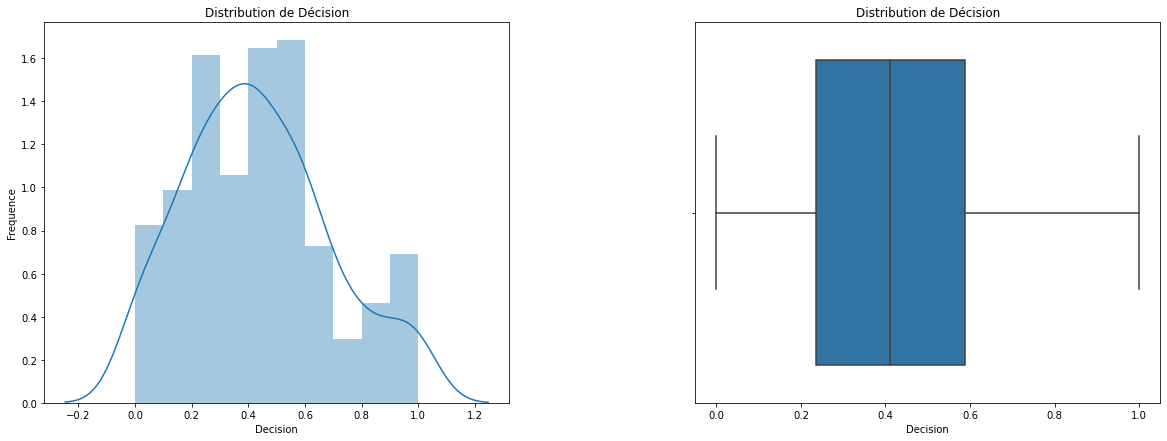

In [30]:
print("Decision moyenne du décideur : Mean = {} ; SD = {}".format(round(np.mean(dec_agg_iid.dec),2), round(np.std(dec_agg_iid.dec),2)))
print("")

fig = plt.figure(figsize=(20, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
sns.distplot(dec_agg_iid["dec"]).set(title='Distribution de Décision', xlabel='Decision', ylabel='Frequence')
ax = fig.add_subplot(1, 2, 2)
sns.boxplot(dec_agg_iid["dec"]).set(title='Distribution de Décision', xlabel='Decision')
plt.show()

Les participants à l'étude souhaitent revoir en moyenne 43% de leurs dates. Cependant, on constate une importante variabilité avec un minimum de 0% et un maximum de 100% des dates pour qui le participant souhaitait donner suite. 
La variable n'est pas tout à fait normalement distribuée avec un léger rebond sur l'extrême (100%).

# 3. Description de l'échantillon de décideurs 

## 3.1. Variables quantitatives

In [31]:
decider_caract_quant = ['age', 'imprace', 'imprelig', 'date', 'go_out', 
                       'sports','tvsports','exercise', 'dining', 'museums', 'art', 'hiking', 'clubbing', 
                       'reading', 'tv', 'theater', 'concerts', 'music', 'shopping', 'gaming', 'movies', 'yoga', 
                       'exphappy',
                       'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
                       'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 
                       'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o']

df = dec_agg_iid[decider_caract_quant]

In [32]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe().transpose()

count  mean   std   min   25%   50%   75%    max
age      297.00 25.79  3.38 18.00 23.00 26.00 28.00  34.00
imprace  297.00  3.62  2.85  1.00  1.00  3.00  6.00  10.00
imprelig 297.00  3.63  2.83  1.00  1.00  3.00  6.00  10.00
date     296.00  4.97  1.48  1.00  4.00  5.00  6.00   7.00
go_out   297.00  2.13  1.16  1.00  1.00  2.00  3.00   7.00
sports   297.00  6.38  2.65  1.00  4.00  7.00  9.00  10.00
tvsports 297.00  4.60  2.80  1.00  2.00  4.00  7.00  10.00
exercise 297.00  6.30  2.48  1.00  5.00  7.00  8.00  10.00
dining   297.00  7.71  1.82  1.00  7.00  8.00  9.00  10.00
museums  297.00  6.83  2.16  0.00  5.00  7.00  8.00  10.00
art      297.00  6.54  2.38  0.00  5.00  7.00  8.00  10.00
hiking   297.00  5.76  2.57  0.00  4.00  6.00  8.00  10.00
clubbing 297.00  5.72  2.47  0.00  4.00  6.00  8.00  10.00
reading  297.00  7.62  1.98  1.00  6.00  8.00  9.00  13.00
tv       297.00  5.27  2.50  1.00  3.00  6.00  7.00  10.00
theater  297.00  6.67  2.36  0.00  5.00  7.00  9.00  10.00
concerts 297.00  6.84  2.22  0.00  6.00  7.00  8.00  10.00
music    297.00  7.84  1.81  1.00  7.00  8.00  9.00  10.00
shopping 297.00  5.57  2.61  1.00  4.00  6.00  8.00  10.00
gaming   297.00  3.91  2.60  1.00  1.00  4.00  6.00  14.00
movies   297.00  7.93  1.75  0.00  7.00  8.00  9.00  10.00
yoga     297.00  4.26  2.76  0.00  2.00  4.00  6.00  10.00
exphappy 297.00  5.45  1.77  1.00  5.00  5.00  7.00  10.00
attr1_1  297.00 24.85 14.68  0.00 15.00 20.00 30.00 100.00
sinc1_1  297.00 16.84  7.90  0.00 10.00 18.00 20.00  60.00
intel1_1 297.00 20.35  7.93  0.00 16.00 20.00 25.00  50.00
fun1_1   296.00 17.58  7.26  0.00 11.78 20.00 20.00  50.00
amb1_1   295.00  9.89  6.57  0.00  5.00 10.00 15.00  53.00
shar1_1  295.00 10.85  6.74  0.00  5.00 10.00 15.00  30.00
attr3_1  296.00  6.96  1.43  2.00  6.00  7.00  8.00  10.00
sinc3_1  296.00  8.11  1.48  2.00  7.00  8.00  9.00  10.00
fun3_1   296.00  7.68  1.59  2.00  7.00  8.00  9.00  10.00
intel3_1 296.00  8.30  1.12  3.00  8.00  8.00  9.00  10.00
amb3_1   296.00  7.53  1.83  2.00  7.00  8.00  9.00  10.00
attr_o   303.00  6.22  1.18  2.80  5.42  6.31  7.08   8.50
sinc_o   303.00  7.21  0.68  4.47  6.81  7.25  7.67   8.80
intel_o  303.00  7.38  0.61  4.80  6.95  7.43  7.81   8.80
fun_o    303.00  6.42  1.05  2.62  5.76  6.59  7.19   8.50
amb_o    303.00  6.81  0.78  4.00  6.29  6.75  7.33   8.60
shar_o   303.00  5.50  1.00  1.38  4.87  5.53  6.13   7.70

In [33]:
cols = df.columns
labels = ['Age', 'Importance de l Ethnie', 'Importance de la Religion', 'Habitude de dating', 'Habitude de sortie', 
                       'Intérêt : Sports','Intérêt : Sport à la TV','Intérêt : Exercise', 'Intérêt : Restaurant', 'Intérêt : Musees', 'Intérêt : Art', 'Intérêt : Randonnée', 'Intérêt : Clubbing', 
                       'Intérêt : Lecture', 'Intérêt : TV', 'Intérêt : Theatre', 'Intérêt : Concerts', 'Intérêt : Musique', 'Intérêt : Shopping', 'Intérêt : Jeux video', 'Intérêt : Films', 'Intérêt : Yoga', 
                       'Bonheur',
                       'Recherche : Attractivité', 'Recherche : Sincerite', 'Recherche : Intelligence', 'Recherche : Amusant', 'Recherche : Ambition', 'Recherche : Partage de centres d intérêt',
                       'Perception de Soi : Attractivité', 'Perception de Soi : Sincerité', 'Perception de Soi : Amusant', 'Perception de Soi : Intelligence', 'Perception de Soi : Ambition', 
                       'Perception par autrui : Attractivité', 'Perception par autrui : Sincerité', 'Perception par autrui : Intelligence', 'Perception par autrui : Amusant', 'Perception par autrui : Ambition', 'Perception par autrui : Partage de centres d intérêt']

my_buttons = [dict(method = "update",
                   args = [{'x': [ df[c] ]}, {"xaxis.title": c} ],
                   label = labels[k]) for k, c in enumerate(cols)]

fig = px.histogram(df, x = 'age')

fig.update_layout(width=1000, height=600,
                 updatemenus=[dict(active=0,
                                   x= 1, y=1, 
                                   xanchor='left', 
                                   yanchor='top',
                                   buttons=my_buttons)
                              ]) 


Après examen des variables quantitatives : 
- Age : Mean = 25.8 [18-34]
- Imprace : La race importe peu à la mojorité des répondants (Mean 3.6)
- Imprelig : La religion importe peu à la mojorité des répondants (Mean 3.6)
- Date : La distribution est assymétrique et indique ainsi que les participants ont davantage tendance à peu faire de dates que beaucoup
- Go_out : A l'inverse, l'assymétrie de cette variable indique que les participants ont tendance à sortir souvent voire très souvent. 
- Pour les centres d'intérêt : 
    - Asym Plafond : Musique (Med = 8), Movies (Med = 8), Sport (Med = 7), Exercice (Med = 7), Diners (Med = 7), Musees (Med = 7), Art (Med = 7), Hiking (Med = 6), Theater (Med = 7), Concerts (Med = 7)
    - Clubbing (Med = 6) et Reading (Med = 8) ~ Sans note + extreme, 
    - Asym plancher : Shopping (Med = 6), TV (Med = 6), Sport à la TV (Med = 6), Yoga (Med = 4), Gaming (Med = 4)
- Pour les caracteristiques recherchées chez autrui : 
    - Attractivité (Med = 20), Intelligence (Med = 20), Fun (Med = 20)
    - Sincerité (Med = 18)
    - Ambition (Med = 10), Partage de centres d'intéret (Med = 10)
- Self Perception du décideur : 
    - Sincerité (Med = 8), Fun (Med = 8), Intelligence (Med = 8), Ambition (Med = 8)
    - Attractivité (Med = 7)
- Perception par autrui : 
    - Sincerité (Med = 7), Fun (Med = 6.6), Intelligence (Med = 7.4), Ambition (Med = 6.7)
    - Attractivité (Med = 6.3)
    - Partage de centres d'intérêt (Med = 5.5)

Globalement les personnes se percoivent sous un meilleur jour que ce qu'ils sont percus par autrui.

## 3.2. Variables qualitatives

In [34]:
dec_agg_iid['gender'] = dec_agg_iid['gender'].replace([0,1],['Female', 'Male'])
dec_agg_iid['race'] = dec_agg_iid['race'].replace([1,2,3,4,5,6],['African American', 'Caucasian American', 'Hispanic American', 'Asian American', 'Native American', 'Other'])
dec_agg_iid['goal'] = dec_agg_iid['goal'].replace([1,2,3,4,5,6],['Fun night out', 'Meet new people', 'Get a date', 'Serious relationship', 'I did it', 'Other'])
decider_caract_qual = ['gender', 'race', 'goal']

In [35]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dec_agg_iid[decider_caract_qual].describe().transpose()

count unique                 top freq
gender   303      2                Male  153
race     298      5  Caucasian American  172
goal     297      6       Fun night out  124

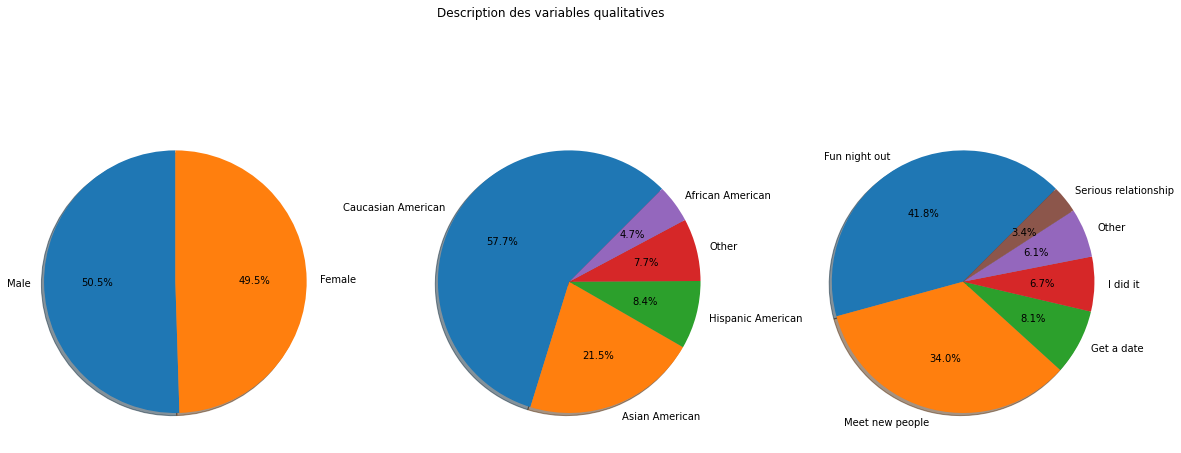

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
fig.suptitle('Description des variables qualitatives')

axes[0].pie(dec_agg_iid['gender'].value_counts(), labels=dec_agg_iid['gender'].value_counts().index, autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[1].pie(dec_agg_iid['race'].value_counts(), labels=dec_agg_iid['race'].value_counts().index, autopct='%1.1f%%',
        shadow=True, startangle=45)
axes[2].pie(dec_agg_iid['goal'].value_counts(), labels=dec_agg_iid['goal'].value_counts().index, autopct='%1.1f%%',
        shadow=True, startangle=45)
plt.show()           


Après examen des variables : 
- Gender : 153 Hommes pour 150 Femmes
- Field : Très variable avec une cat sur-représentée et une presque vide. En l'absence de recodage, cette variable nous semble difficile à explorer. Elle sera ignorée dans cette première approche. 
- Race : 172 Caucasiens - Ecrasante majorité - avec un minimum de 14 African Americans (gros déséquilibre)
- From : Variable très disparate qui nécessiterait un recodage intense (état? région?...). 241 personnes sont regroupées dans "autres valeurs" (171). En l'absence de recodage, cette variable nous semble difficile à explorer. Elle sera ignorée dans cette première approche. 
- ZipCode : Variable très disparate qui nécessiterait un recodage intense (état? région?...). 231 personnes sont regroupées dans "autres valeurs" (227). En l'absence de recodage, cette variable nous semble difficile à explorer. Elle sera ignorée dans cette première approche. 
- Goal : Pour la majorité des répondants, le but de la participation est de passer un bon moment (Seemed like a fun night out) et de rencontrer de nouvelles personnes
- Career : Très variable avec une cat sur-représentée et de nombreuses presque vides. En l'absence de recodage, cette variable nous semble difficile à explorer. Elle sera ignorée dans cette première approche. 

# 4. Relations entre la décision et les caracteristiques du décideur

### 4.1. Relations bivariées

#### 4.1.1. Variables quantitatives

##### 4.1.1.1. Matrice des corrélations

**Global**

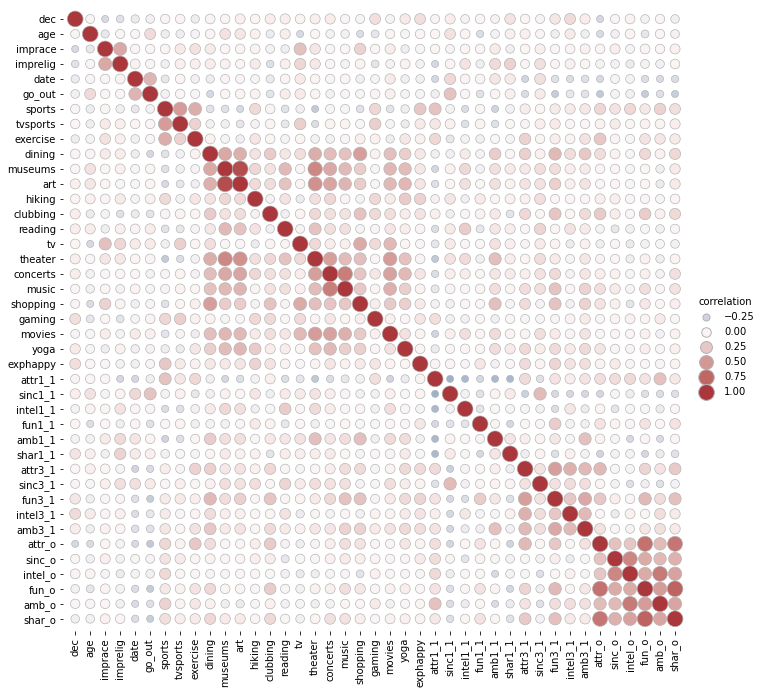

In [37]:
# Compute a correlation matrix and convert to long-form
corr_mat = dec_agg_iid[['dec'] + decider_caract_quant].corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

Cette matrice de corrélations bien qu'un peu grande et donc peu parlante dans le détail, a l'avantage de révéler certains patterns, certains groupements d'items. 

- Il existe de fortes corrélations entre les perceptions d'autrui. Les évaluations faites par les partenaires ne sont pas indépendantes les unes des autres selon les dimensions évaluées. Autrement dit, évaluer l'attractivité n'est pas indépendant du fait d'évaluer le fait de partager des centres d'intérêt. Il doit y avoir un impact assez importante de la valence de l'interaction et de l'impression en général qui vient contaminer les différentes dimensions évaluées. 
- Ces mêmes corrélations existent mais moins fortement concernant les auto évaluations. Les participants décorrélent un peu plus les différentes dimensions d'évaluation que ne le font les partenaires. 
- Il n'existe pas de corrélation évidente entre les dimensions recherchées chez un partenaire. Donc il semble que ces dimensions puissent apparaitre comme indépendantes les unes des autres aux participants, même si lors de l'évaluation des personnes sur ces mêmes dimensions, des relations importantes apparaissent. 
- Concernant les centres d'intérêt, on voit des corrélations exister entre les différentes activités mais un petit noyau assez indépendant se dessine, composé des loisirs : Sports, Sport à la TV et exercice. 
- L'importance de l'Ethnie et celle de la religion sont assez corrélées. 

En revanche, de prime abord, l'enclin à aller vers un second RDV ne montre pas de corrélation avec les caractéristiques investiguées ici. 

**Détails**

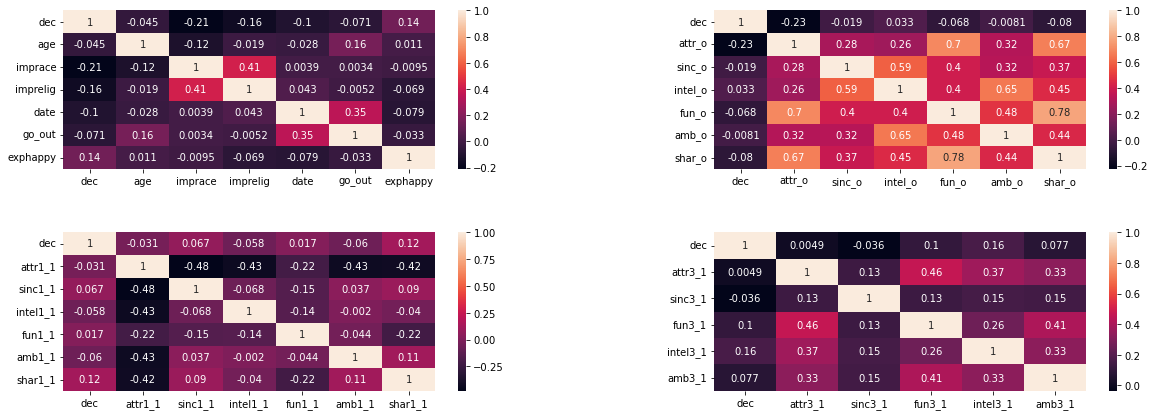

In [38]:
# Matrices de correlation 

corr1 = dec_agg_iid[['dec'] + decider_caract_quant[0:5] + ['exphappy']].corr() 
corr2 = dec_agg_iid[['dec'] + decider_caract_quant[5:22]].corr() 
corr3 = dec_agg_iid[['dec'] + decider_caract_quant[23:29]].corr() 
corr4 = dec_agg_iid[['dec'] + decider_caract_quant[29:34]].corr() 
corr5 = dec_agg_iid[['dec'] + decider_caract_quant[34:]].corr() 

# Heatmaps 

fig = plt.figure(figsize=(20, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.heatmap(corr1, annot=True, ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.heatmap(corr5, annot=True, ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.heatmap(corr3, annot=True, ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.heatmap(corr4, annot=True, ax=ax)
plt.show()

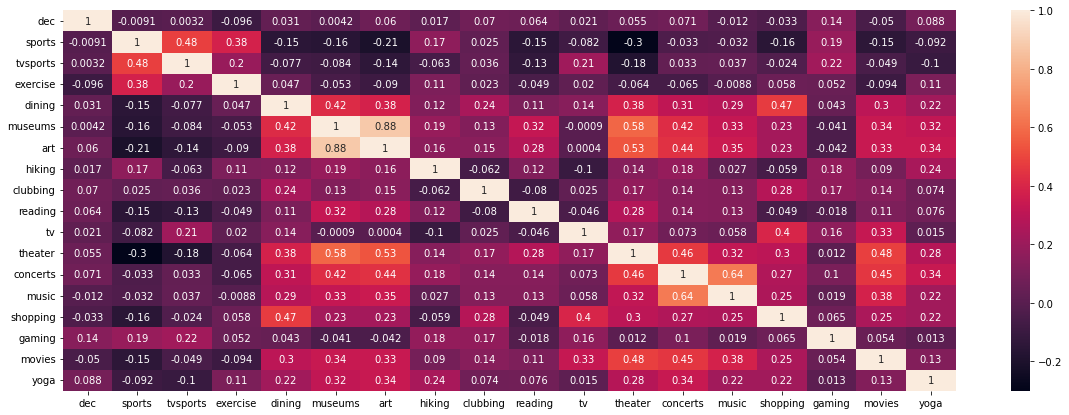

In [39]:
fig = plt.figure(figsize=(20, 7))
sns.heatmap(corr2, annot=True)
plt.show()

L'examen des correlations (> .2) nous amène à considérer les relations entre Decision et 
- Imprace (-0.21)
- Attr_o (-0.23)

##### 4.1.1.2. Représentations graphiques

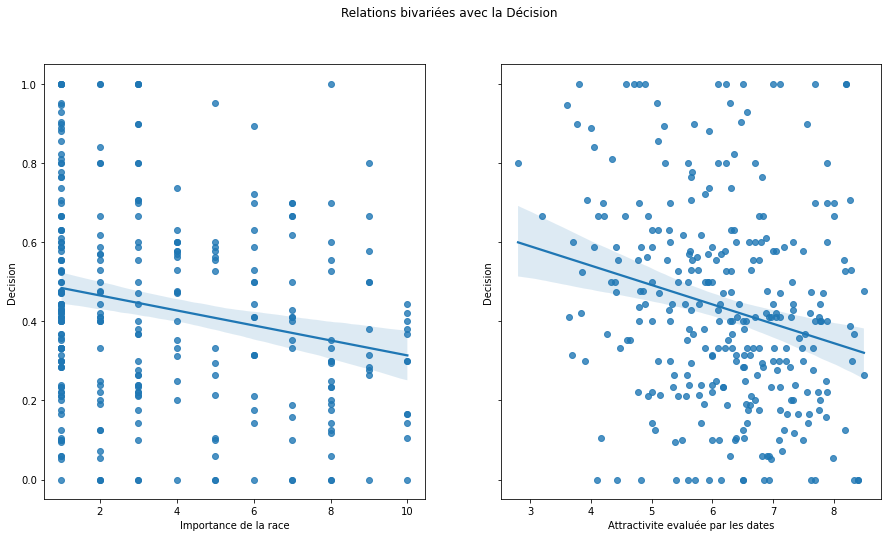

In [40]:
caract_linked = ['imprace', 'attr_o']
caract_label = ['Importance de la race', 'Attractivite evaluée par les dates']

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
fig.suptitle('Relations bivariées avec la Décision')

for i in [0,1]:
    sns.regplot(ax=axes[i], 
                data = dec_agg_iid, 
                x = caract_linked[i], 
                y = 'dec').set(xlabel = caract_label[i], ylabel = 'Decision')

Les caractéristiques quantitatives les + corrélées à la propension à souhaiter un second rendez-vous sont : 
- L'importance de l'Ethnie (corr = -0.21) : Plus l'ethnie du partenaire est importance pour une personne, moins celle-ci est encline à demander des 2nd rendez-vous. Cela fait sens, puisque cela rajoute un critère de sélection que n'ont pas les personnes pour qui l'ethnie n'est pas importante. 
- L'attractivité du décideur perçue par les partenaires (corr = -0.23): Moins le décideur est perçu comme attractif, plus il est enclin à souhaiter des 2nd rendez-vous. "Plus on est attractif, plus on est difficile."

Cependant, ces corrélations restent **très faibles** et donc les relations doivent être considérées avec précaution en l'attente de tests statistiques + avancés. 

#### 4.1.2. Variables qualitatives

##### 4.1.2.1. Résultats des Chi²

In [41]:
for var in decider_caract_qual : 
    res = stat()
    formula = 'dec ~ C(' + var + ')'
    res.anova_stat(df=dec_agg_iid, res_var = 'dec', anova_model = formula)
    print('Effet de {} - p value  = {}'.format(var, round(res.anova_summary['PR(>F)'][0],3)))

Effet de gender - p value  = 0.004
Effet de race - p value  = 0.173
Effet de goal - p value  = 0.185


##### 4.1.2.2. Représentation graphique

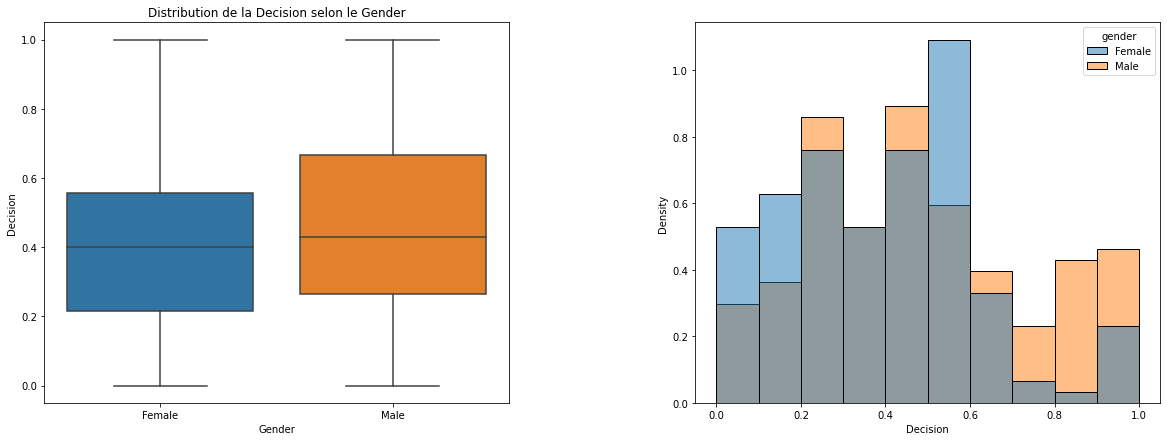

In [42]:

fig = plt.figure(figsize=(20, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
sns.boxplot(x='gender', y='dec', data=dec_agg_iid).set(title='Distribution de la Decision selon le Gender', xlabel='Gender', ylabel='Decision')
ax = fig.add_subplot(1, 2, 2)
sns.histplot(dec_agg_iid, x = "dec", hue = "gender", stat='density').set(xlabel = "Decision")
plt.show()


Les hommes ont tendance à davantage souhaiter un second rendez-vous que les femmes (essentiellement porté par des comportements extremes). 

### 4.2. Relations multivariées

#### 4.2.1 Ethnie * Genre

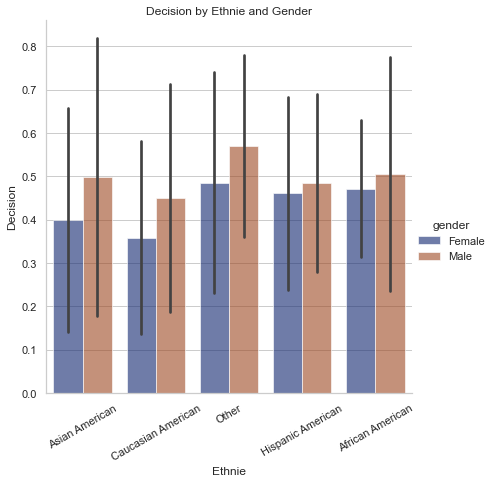

In [43]:
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=dec_agg_iid, kind="bar",
    x="race", y="dec", hue="gender",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.set(xlabel = "Ethnie", ylabel = "Decision", title = "Decision by Ethnie and Gender")
g.set_xticklabels(rotation=30)

plt.show()

La différence Hommes - Femmes est moins marquée chez les hispaniques et les African American que chez les autres Ethnies chez qui les hommes sont plus enclins à souhaiter un second rdv

#### 4.2.1 Variables Continues * Genre

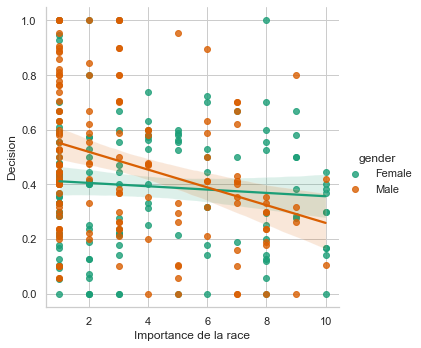

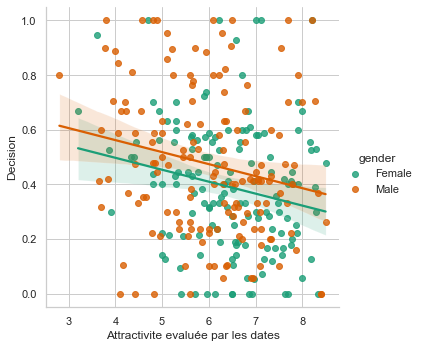

In [44]:

caract_linked = ['imprace', 'attr_o']
caract_label = ['Importance de la race', 'Attractivite evaluée par les dates']

for i in range(len(caract_linked)):
    sns.lmplot(
               data = dec_agg_iid, 
                hue = 'gender',
                x = caract_linked[i], 
                y = 'dec',
                palette='Dark2').set(xlabel = caract_label[i], ylabel = 'Decision')


In [45]:
#sns.jointplot(data=dec_agg_iid, x="imprace", y="dec", hue="gender")
#sns.jointplot(data=dec_agg_iid, x="attr_o", y="dec", hue="gender")

L'effet de l'attractivité évaluée par les partenaires sur le taux de décisions positives est similaire pour les hommes et les femmes (+ on est attractif, moins on donne suite). 

A l'inverse, l'effet de l'importance de l'ethnie du partnaire sur le taux de décisions positives diffère selon le genre du décideur. En effet, cet effet est + important pour les hommes et presque inexistant chez les femmes. 

#### 4.2.1 Attractivité du décideur * Age * Genre

<AxesSubplot:>

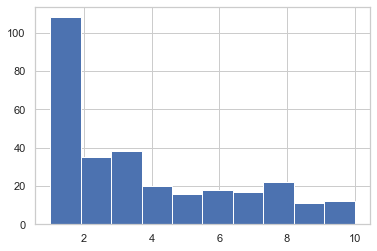

In [47]:
dec_agg_iid['imprace'].hist()

In [46]:
dec_agg_iid['imprace'].describe()

count   297.00
mean      3.62
std       2.85
min       1.00
25%       1.00
50%       3.00
75%       6.00
max      10.00
Name: imprace, dtype: float64

La variable Importance de l'ethnie étant particulièrement assymétrique, elle a été catégorisée à l'aide de ses quantiles : 1 à 3, 3 à 6, 6 et +

In [48]:
dec_agg_iid['imprace'] = dec_agg_iid['imprace'].fillna(dec_agg_iid['imprace'].median())
dec_agg_iid['imprace3'] = dec_agg_iid['imprace'].replace([1,2,3,4,5,6,7,8,9,10],[1,1,2,2,2,3,3,3,3,3])

fig = px.scatter(dec_agg_iid, x="attr_o", y="dec", animation_frame="imprace3", color = "gender", category_orders = {'imprace3': [1,2,3]}, trendline="ols")
fig.show()

On constate ici que lorsque l'ethnie n'est pas importante, la relation entre attractivité perçue par autrui et décision est identique pour les hommes et les femmes (+ on est perçu comme attractif, moins on est enclin à donner suite). 
Pour une importance de l'ethnie moyenne (3 à 6), cette relation est plus importante pour les hommes que pour les femmes. 
En revanche, pour une haute importance de l'ethnie (6 et plus), c'est pour les femmes que cette relation s'accentue.  
Cependant, on manque de données pour s'en assurer, en effet ici, on voit que pour les personnes qui jugent l'ethnie moyennement ou hautement importante, on a un déséquilibre des autres variables puisque les personnes jugées peu attractives sont essentiellement des hommes. 

In [51]:
fig = px.scatter_3d(dec_agg_iid, x='attr_o', y='dec', z='imprace', color='gender')
fig.update_traces(marker_size = 3)
fig.show()

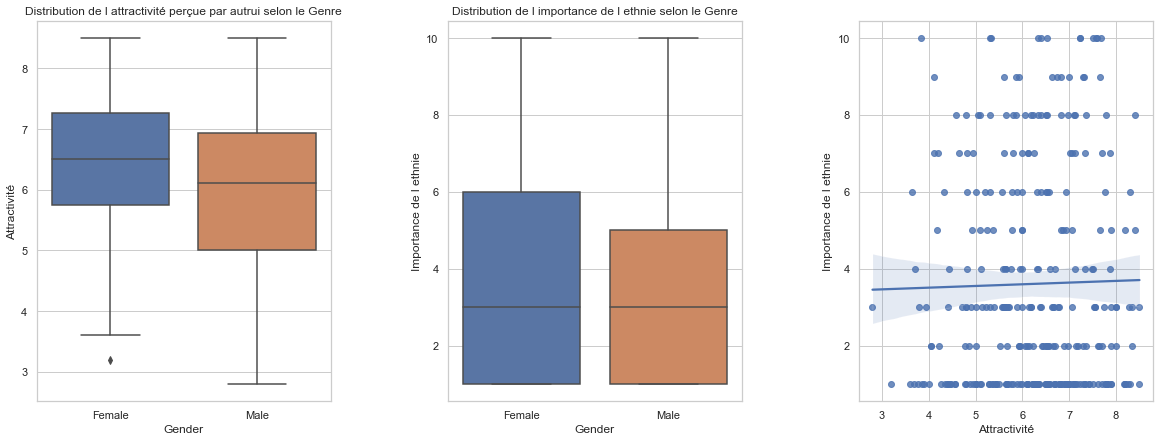

In [61]:
fig = plt.figure(figsize=(20, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 3, 1)
sns.boxplot(x='gender', y='attr_o', data=dec_agg_iid).set(title='Distribution de l attractivité perçue par autrui selon le Genre', xlabel='Gender', ylabel='Attractivité');
ax = fig.add_subplot(1, 3, 2)
sns.boxplot(x='gender', y='imprace', data=dec_agg_iid).set(title='Distribution de l importance de l ethnie selon le Genre', xlabel='Gender', ylabel='Importance de l ethnie');
ax = fig.add_subplot(1, 3, 3)
sns.regplot(data = dec_agg_iid, x = 'attr_o', y = 'imprace').set(xlabel = 'Attractivité', ylabel = 'Importance de l ethnie');

En effet, les hommes sont à la fois perçues comme en moyenne moins attractifs et sont peut être un peu moins concernés par une haute importance de l'ethnie (même si on a les mêmes médianes). 

En conclusion, l'interaction entre les caractéristiques retenues doit être interprétée avec grande précaution et on préférera retenir uniquement les relations univariées :  
- Les hommes sont plus enclins à donner suite
- Les personnes jugées comme moins attractives sont plus inclines à donner suite
- Les personnes pour qui l'ethnie est importantes sont moins inclines à donner suite